In [1]:
!pip install -q kagglehub
import kagglehub
import os

print("Downloading dataset...")
dataset_path = kagglehub.dataset_download("dasmehdixtr/ddti-thyroid-ultrasound-images")
print(f"Dataset downloaded to: {dataset_path}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Dataset downloaded to: /teamspace/studios/this_studio/.cache/kagglehub/datasets/dasmehdixtr/ddti-thyroid-ultrasound-images/versions/1


In [2]:
import os
import json
import numpy as np
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re

# Constants
IMG_SIZE = (256, 256)

def load_data_ddti_smart(base_path, img_size=IMG_SIZE):
    images = []
    masks = []
    
    # --- Step 1: Index all images ---
    # We create a map: ID -> File Path
    # We store IDs as both strings ("001") and integers (1) to handle padding differences
    image_map = {}
    
    print("Indexing images...")
    count = 0
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif')):
                full_path = os.path.join(root, file)
                base_name = os.path.splitext(file)[0]
                
                # Map the exact string
                image_map[base_name] = full_path
                
                # Map the integer value if numeric (handles 001.jpg vs 1)
                # Find all numbers in filename
                nums = re.findall(r'\d+', base_name)
                if nums:
                    # Usually the filename IS the number (e.g. "1.jpg" or "001.jpg")
                    # We take the longest number sequence as the ID
                    files_id_num = int(max(nums, key=len))
                    image_map[files_id_num] = full_path
                
                count += 1

    print(f"Indexed {count} images. Map size: {len(image_map)}")

    # --- Step 2: Scan XMLs and link to images ---
    print("Processing XML annotations...")
    
    xml_files = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.xml'):
                xml_files.append(os.path.join(root, file))
    
    pairs_found = 0
    
    for xml_path in xml_files:
        try:
            tree = ET.parse(xml_path)
            root_xml = tree.getroot()
            
            # DDTI XML structure: <case> ... <mark><image>ID</image><svg>...</svg></mark> ... </case>
            # We iterate over all 'mark' tags to find image references
            marks = root_xml.findall('.//mark')
            
            for mark in marks:
                # 1. Find which image this annotation belongs to
                image_tag = mark.find('image')
                if image_tag is None or not image_tag.text:
                    continue
                    
                image_id_str = image_tag.text.strip()
                
                # Try to find the image in our map
                img_path = None
                
                # Try exact string match
                if image_id_str in image_map:
                    img_path = image_map[image_id_str]
                # Try integer match
                elif image_id_str.isdigit() and int(image_id_str) in image_map:
                    img_path = image_map[int(image_id_str)]
                
                if img_path is None:
                    # Fallback: Try matching the XML filename itself
                    xml_base = os.path.splitext(os.path.basename(xml_path))[0]
                    if xml_base in image_map:
                        img_path = image_map[xml_base]
                
                if img_path is None:
                    continue

                # 2. Process the Image
                img = cv2.imread(img_path)
                if img is None: continue
                
                original_h, original_w = img.shape[:2]
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img, img_size)
                
                # 3. Process the Mask (SVG JSON)
                svg_data = mark.find('svg')
                mask = np.zeros((original_h, original_w), dtype=np.uint8)
                mask_created = False
                
                if svg_data is not None and svg_data.text:
                    try:
                        # Clean the text if necessary (sometimes has quotes issues)
                        json_text = svg_data.text
                        shapes = json.loads(json_text)
                        
                        for shape in shapes:
                            points = shape.get('points', [])
                            if points:
                                pts = np.array([[int(p['x']), int(p['y'])] for p in points], dtype=np.int32)
                                cv2.fillPoly(mask, [pts], 255)
                                mask_created = True
                    except Exception as e:
                        # print(f"JSON error in {xml_path}: {e}")
                        pass
                
                # Only add if we found a mask or if we accept empty masks (for benign cases)
                # Here we assume we want positive samples mainly, but let's add it
                if mask_created:
                    mask_resized = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
                    mask_resized = np.expand_dims(mask_resized, axis=-1)
                    
                    images.append(img_resized / 255.0)
                    masks.append(mask_resized / 255.0)
                    pairs_found += 1

        except Exception as e:
            print(f"Error parsing XML {xml_path}: {e}")
            continue

    print(f"Successfully paired and processed {pairs_found} image-mask pairs.")
    return np.array(images), np.array(masks)

# Load Data
X, Y = load_data_ddti_smart(dataset_path)

if len(X) > 0:
    print(f"Final Data Shape: {X.shape}")
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
else:
    raise ValueError("Still no data found! Check if the dataset path contains the expected files.")

Indexing images...
Indexed 480 images. Map size: 870
Processing XML annotations...
Successfully paired and processed 466 image-mask pairs.
Final Data Shape: (466, 256, 256, 3)


In [3]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_feature_fusion_network(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    up1 = UpSampling2D((2, 2))(bottleneck)
    deconv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    concat1 = Concatenate()([deconv1, conv2])

    up2 = UpSampling2D((2, 2))(concat1)
    deconv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    concat2 = Concatenate()([deconv2, conv1])

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(concat2)

    return Model(inputs, outputs)

model = build_feature_fusion_network()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2025-11-20 05:21:53.423857: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-20 05:21:53.617399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763616113.685776    2980 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763616113.703680    2980 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763616113.865627    2980 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    295,040 │ up_sampling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_3[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 256, 256,  │          0 │ concatenate[0][0] │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 256, 256,  │    147,520 │ up_sampling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ conv2d_4[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │        129 │ concatenate_1[0]… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 813,505 (3.10 MB)

 Trainable params: 813,505 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

Running Adaptive Visualization...


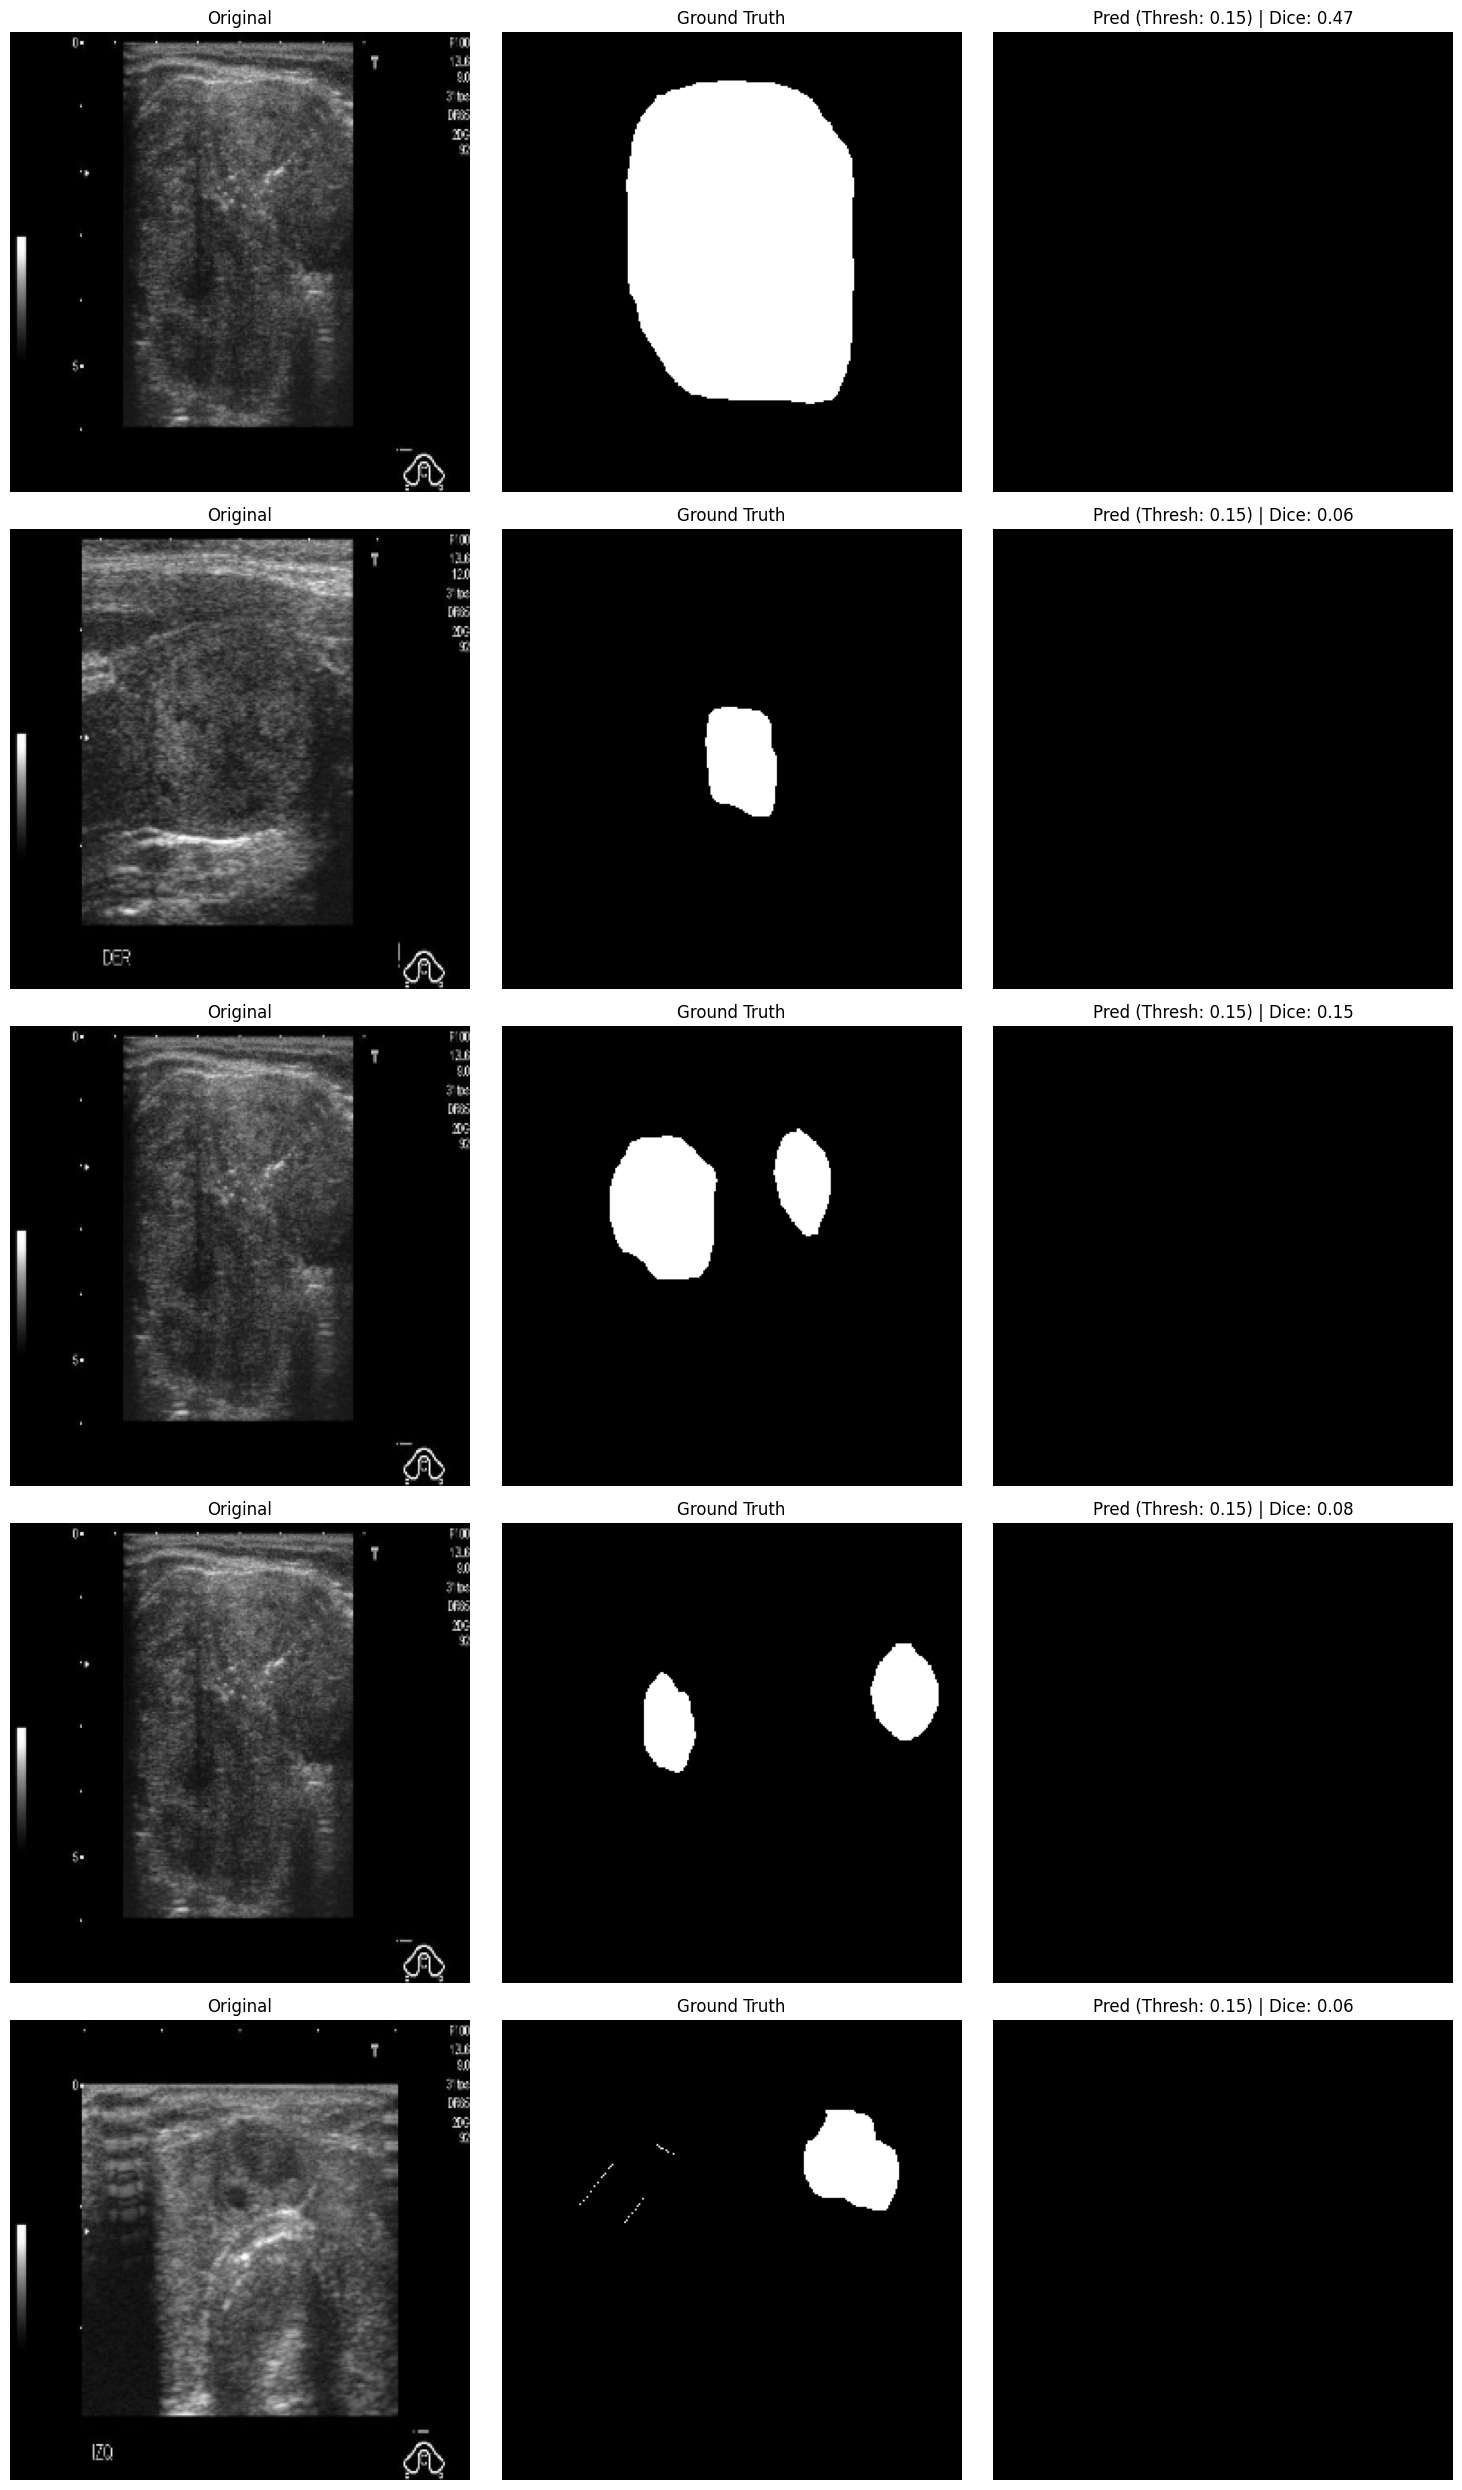

In [4]:
def plot_prediction_adaptive(model, X_val, y_val, num_samples=5):
    indices = np.random.choice(len(X_val), num_samples, replace=False)
    
    plt.figure(figsize=(15, 5 * num_samples))

    for i, idx in enumerate(indices):
        img = X_val[idx]
        true_mask = y_val[idx]
        
        # Predict
        pred_prob = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
        
        # --- ADAPTIVE THRESHOLDING ---
        # If the model is shy, we lower the threshold to 0.15 instead of 0.5
        max_val = pred_prob.max()
        if max_val > 0.15:
            # Use a lower threshold
            threshold = 0.15 
            pred_mask = (pred_prob > threshold).astype(np.float32)
        else:
            # If max is tiny, it really thinks there is nothing there
            pred_mask = np.zeros_like(pred_prob)
            threshold = 0.5

        # Calculate Dice
        intersection = np.sum(true_mask * pred_mask)
        dice = (2. * intersection) / (np.sum(true_mask) + np.sum(pred_mask) + 1e-6)

        # Plot
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title(f"Original")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title(f"Pred (Thresh: {threshold}) | Dice: {dice:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

print("Running Adaptive Visualization...")
plot_prediction_adaptive(model, X_val, y_val, num_samples=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
--- DIAGNOSTIC FOR IMAGE 32 ---
Max Predicted Probability: 0.99865
Avg Predicted Probability: 0.21580


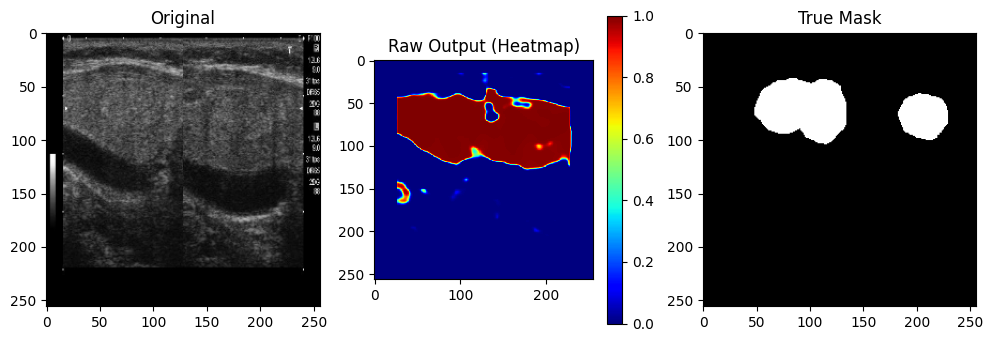

In [9]:
# Pick a random image from validation
idx = np.random.randint(0, len(X_val))
img = X_val[idx]
mask = y_val[idx]

# Predict raw probabilities (no threshold)
pred_raw = model.predict(np.expand_dims(img, axis=0))[0]

print(f"--- DIAGNOSTIC FOR IMAGE {idx} ---")
print(f"Max Predicted Probability: {pred_raw.max():.5f}")
print(f"Avg Predicted Probability: {pred_raw.mean():.5f}")

# Visual Comparison
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Original")
plt.subplot(1, 3, 2); plt.imshow(pred_raw.squeeze(), cmap='jet', vmin=0, vmax=1); plt.title("Raw Output (Heatmap)")
plt.colorbar()
plt.subplot(1, 3, 3); plt.imshow(mask.squeeze(), cmap='gray'); plt.title("True Mask")
plt.show()

--- DEBUGGING WITH INTEGER MATCHING ---
Total Images Indexed: 390
Example: Mapped 100_1.jpg -> ID 100

Inspecting XML: 27.xml (ID: 27)
SUCCESS: Matched with Image: 27_1.jpg


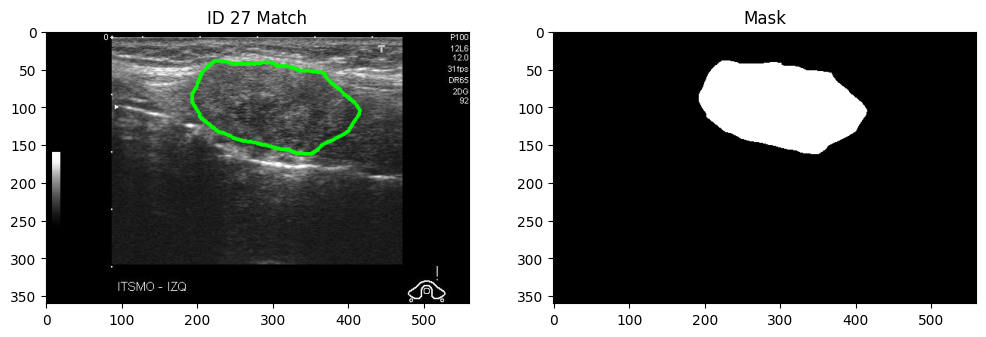

In [6]:
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import re

def debug_ground_truth_integer_match(base_path):
    print("--- DEBUGGING WITH INTEGER MATCHING ---")
    
    # 1. Index all images by their INTEGER value
    image_map = {}
    img_files_found = []
    
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp')):
                # Find all numbers in filename
                nums = re.findall(r'\d+', file)
                if nums:
                    # Use the longest number sequence found as the ID
                    # e.g., "00015" -> 15
                    file_id = int(max(nums, key=len))
                    image_map[file_id] = os.path.join(root, file)
                    img_files_found.append(file)
    
    print(f"Total Images Indexed: {len(image_map)}")
    
    if len(img_files_found) > 0:
        # Fix for f-string backslash error: Calculate ID outside
        first_file = img_files_found[0]
        first_id_list = re.findall(r'\d+', first_file)
        if first_id_list:
            print(f"Example: Mapped {first_file} -> ID {int(max(first_id_list, key=len))}")

    # 2. Pick a random XML and try to match
    xml_files = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.xml'):
                xml_files.append(os.path.join(root, file))
    
    if not xml_files:
        print("No XML files found.")
        return

    # Pick a specific one to test (or random)
    xml_path = xml_files[np.random.randint(0, len(xml_files))]
    filename = os.path.basename(xml_path)
    
    # Extract ID from XML filename
    nums = re.findall(r'\d+', filename)
    if not nums:
        print(f"Skipping {filename} (No number found)")
        return

    xml_id = int(max(nums, key=len)) # "15.xml" -> 15
    
    print(f"\nInspecting XML: {filename} (ID: {xml_id})")
    
    # LOOKUP BY INTEGER
    if xml_id in image_map:
        img_path = image_map[xml_id]
        print(f"SUCCESS: Matched with Image: {os.path.basename(img_path)}")
    else:
        print(f"CRITICAL: Still no image found for ID {xml_id}")
        # Print some available keys to debug
        keys_list = list(image_map.keys())[:10]
        print(f"Available Image IDs (first 10): {keys_list}")
        return

    # 3. Load and Draw to confirm alignment
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Parse XML
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    mask = np.zeros((h, w), dtype=np.uint8)
    
    marks = root.findall('.//mark')
    for mark in marks:
        svg = mark.find('svg')
        if svg is not None and svg.text:
            try:
                shapes = json.loads(svg.text)
                for shape in shapes:
                    points = shape.get('points', [])
                    if points:
                        pts = np.array([[int(p['x']), int(p['y'])] for p in points], dtype=np.int32)
                        cv2.fillPoly(mask, [pts], 255)
                        cv2.polylines(img, [pts], True, (0, 255, 0), 3)
            except:
                pass

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1); plt.imshow(img); plt.title(f"ID {xml_id} Match")
    plt.subplot(1, 2, 2); plt.imshow(mask, cmap='gray'); plt.title("Mask")
    plt.show()

debug_ground_truth_integer_match(dataset_path)

Loading Dataset...
Indexing images by integer ID...
Indexed 390 images.
Universal Loader: Successfully paired 380 images/masks.
Compiling Model...
Starting Training...
Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 3s/step - accuracy: 0.4092 - dice_coef: 0.1779 - loss: 0.8221 - val_accuracy: 0.4976 - val_dice_coef: 0.2614 - val_loss: 0.7412
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.5896 - dice_coef: 0.2793 - loss: 0.7207 - val_accuracy: 0.7094 - val_dice_coef: 0.3538 - val_loss: 0.6510
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.6333 - dice_coef: 0.3049 - loss: 0.6951 - val_accuracy: 0.6314 - val_dice_coef: 0.3547 - val_loss: 0.6476
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.6647 - dice_coef: 0.3206 - loss: 0.6794 - val_accuracy: 0.7269 - val_dice_coef: 0.3711 - val_loss: 0.6339
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 97s 3s/step - accuracy: 0.7065 - dice_coef: 0.3320 - loss: 0.6680 - val_accuracy: 0.7715 - val_dice_coef: 0.3912 

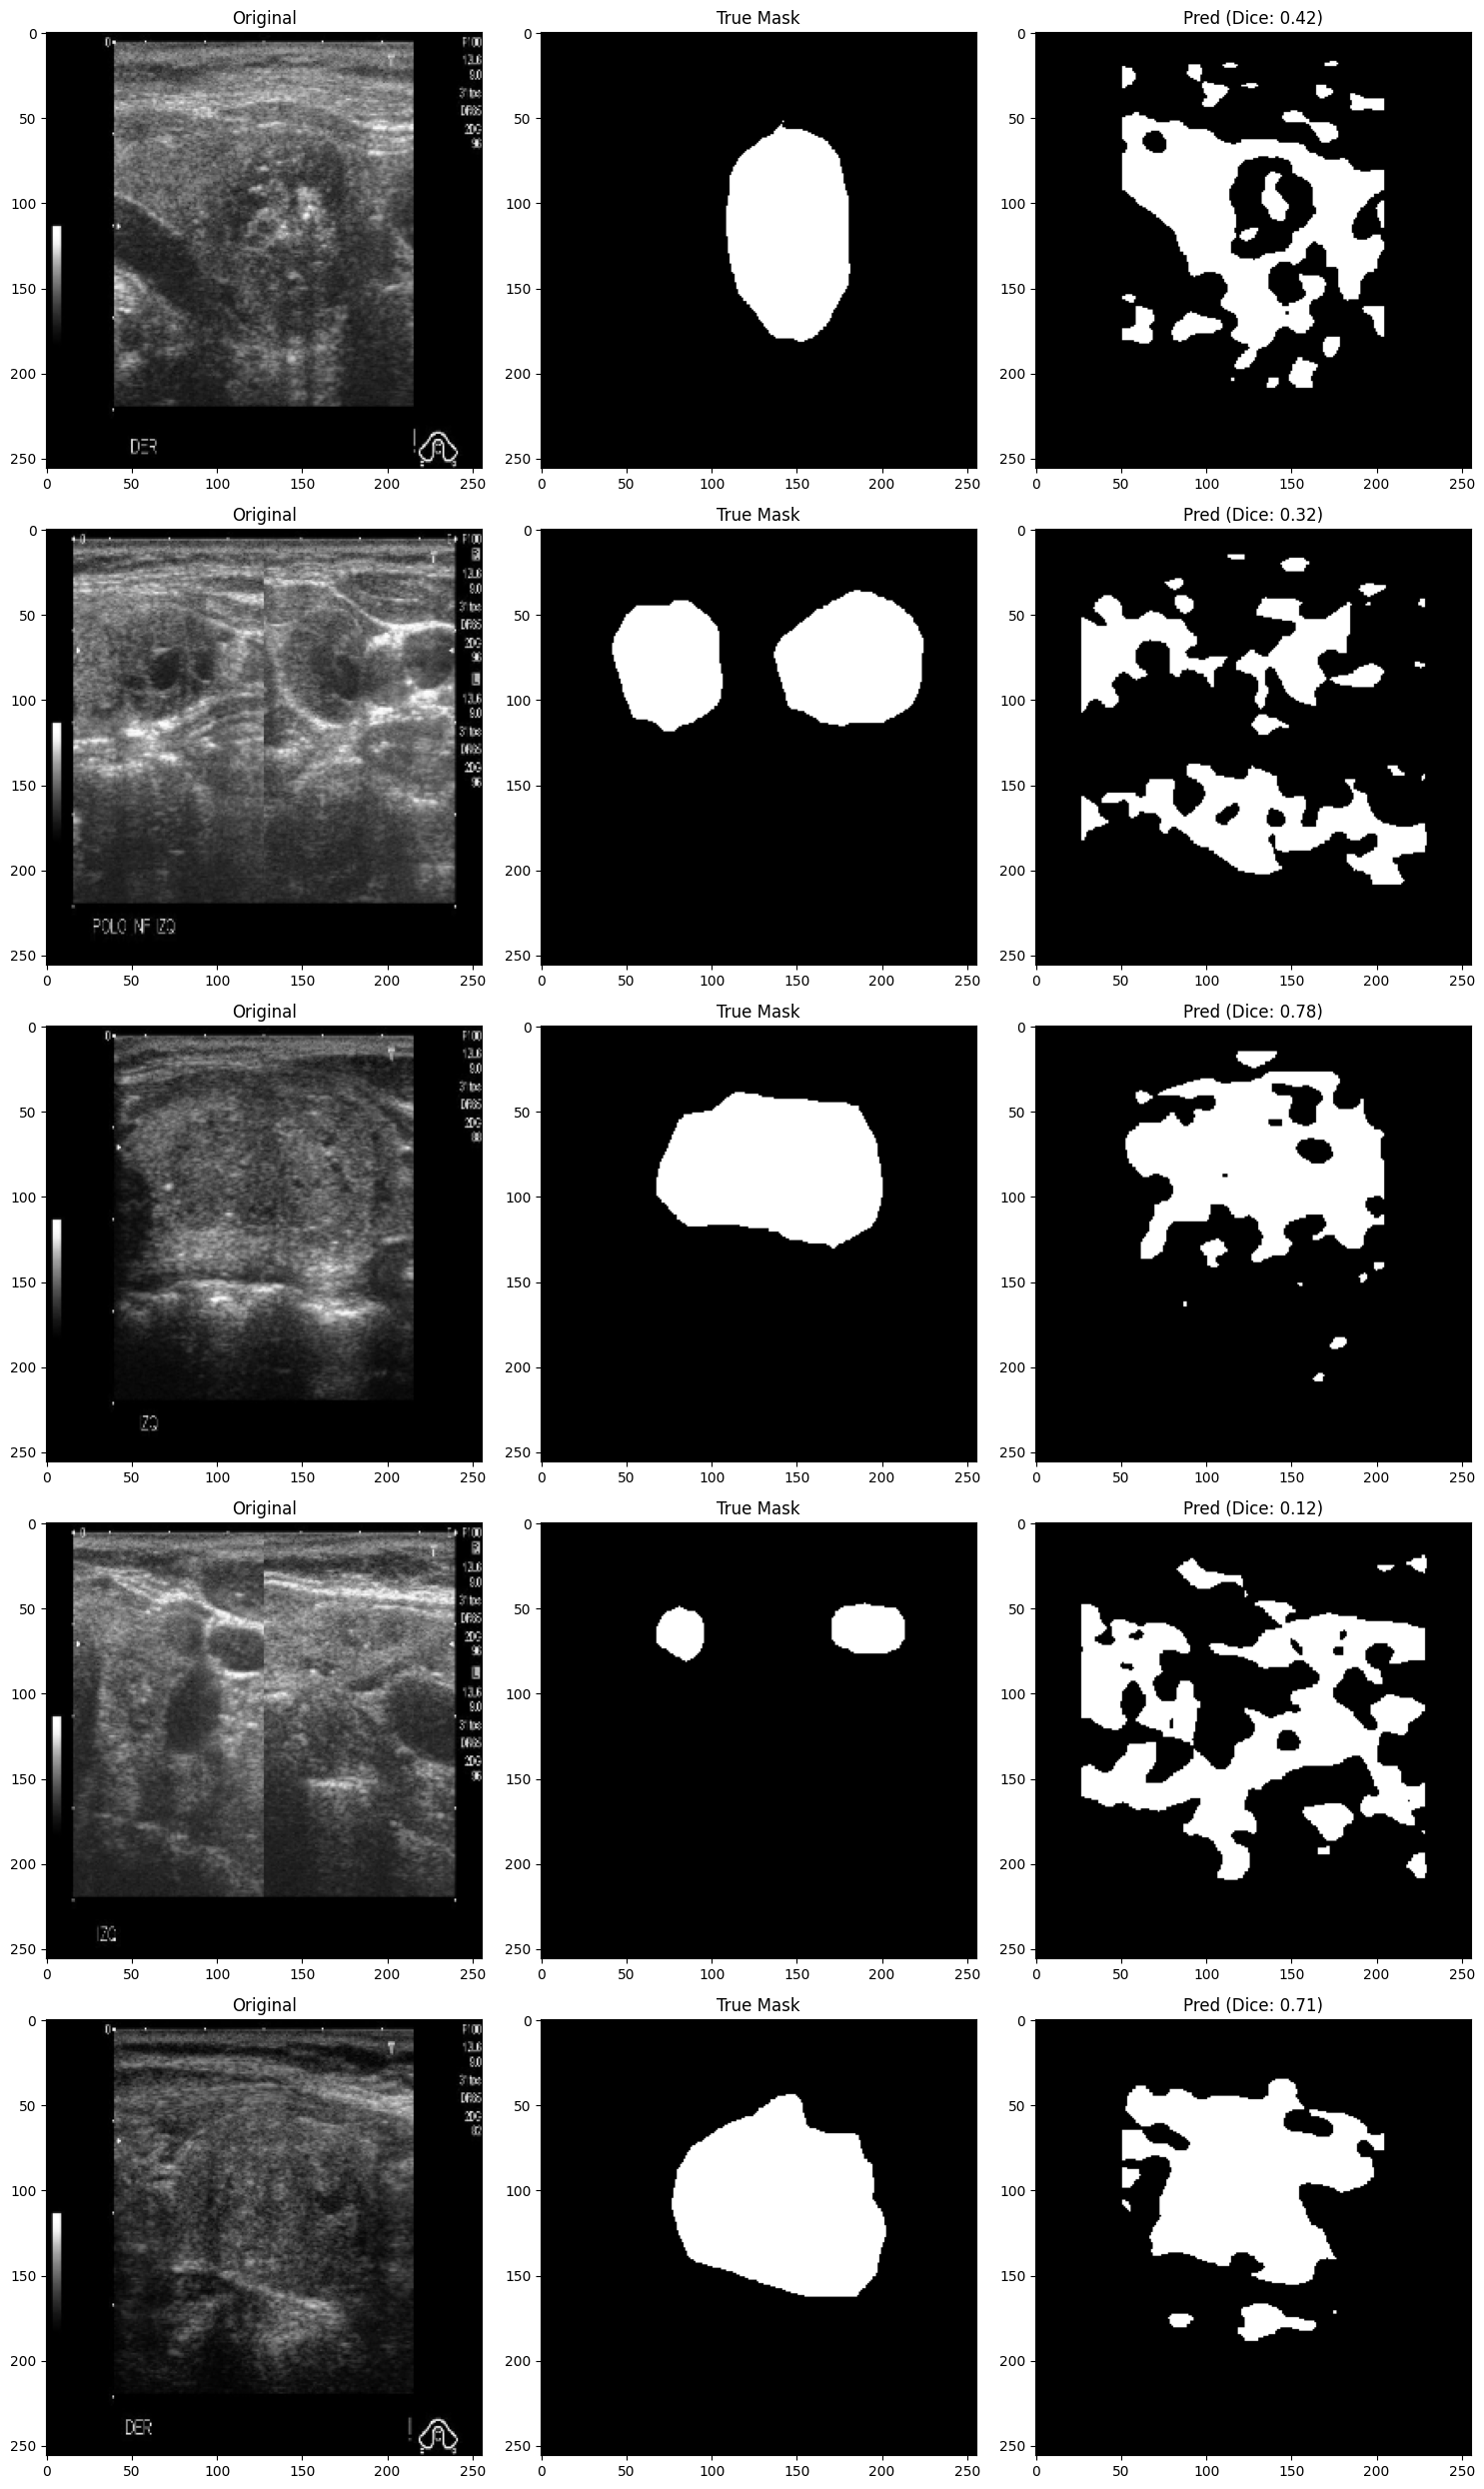

In [7]:
import os
import cv2
import numpy as np
import re
import json
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate

# ==========================================
# 1. DEFINE LOSS FUNCTIONS (Fixes NameError)
# ==========================================
def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# ==========================================
# 2. DEFINE ROBUST DATA LOADER
# ==========================================
def load_data_ddti_universal(base_path, img_size=(256, 256)):
    images = []
    masks = []
    image_map = {}
    
    print("Indexing images by integer ID...")
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp')):
                nums = re.findall(r'\d+', file)
                if nums:
                    # Store "00015.jpg" as key 15
                    key = int(max(nums, key=len)) 
                    image_map[key] = os.path.join(root, file)
    
    print(f"Indexed {len(image_map)} images.")
    
    match_count = 0
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.xml'):
                nums = re.findall(r'\d+', file)
                if not nums: continue
                
                # Match "15.xml" to key 15
                xml_key = int(max(nums, key=len))
                
                if xml_key in image_map:
                    img_path = image_map[xml_key]
                    xml_path = os.path.join(root, file)
                    
                    try:
                        # Load Image
                        img = cv2.imread(img_path)
                        if img is None: continue
                        h, w = img.shape[:2]
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        img_resized = cv2.resize(img, img_size)
                        
                        # Load Mask
                        tree = ET.parse(xml_path)
                        root_xml = tree.getroot()
                        mask = np.zeros((h, w), dtype=np.uint8)
                        mask_found = False
                        
                        marks = root_xml.findall('.//mark')
                        for mark in marks:
                            svg = mark.find('svg')
                            if svg is not None and svg.text:
                                try:
                                    shapes = json.loads(svg.text)
                                    for shape in shapes:
                                        points = shape.get('points', [])
                                        if points:
                                            pts = np.array([[int(p['x']), int(p['y'])] for p in points], dtype=np.int32)
                                            cv2.fillPoly(mask, [pts], 255)
                                            mask_found = True
                                except: pass
                        
                        if mask_found:
                            mask_resized = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)
                            mask_resized = np.expand_dims(mask_resized, axis=-1)
                            
                            images.append(img_resized / 255.0)
                            masks.append(mask_resized / 255.0)
                            match_count += 1
                            
                    except Exception as e:
                        print(f"Error on ID {xml_key}: {e}")
    
    print(f"Universal Loader: Successfully paired {match_count} images/masks.")
    return np.array(images), np.array(masks)

# ==========================================
# 3. DEFINE MODEL ARCHITECTURE
# ==========================================
def build_feature_fusion_network(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    bottleneck = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    up1 = UpSampling2D((2, 2))(bottleneck)
    deconv1 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    concat1 = Concatenate()([deconv1, conv2])
    up2 = UpSampling2D((2, 2))(concat1)
    deconv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    concat2 = Concatenate()([deconv2, conv1])
    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(concat2)
    return Model(inputs, outputs)

# ==========================================
# 4. EXECUTION PIPELINE
# ==========================================

# Load Data
print("Loading Dataset...")
X, Y = load_data_ddti_universal(dataset_path)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# Build & Compile
print("Compiling Model...")
model = build_feature_fusion_network()
model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy', dice_coef])

# Train
print("Starting Training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15, 
    batch_size=8,
    verbose=1
)

# Save
model.save("thyroid_final_corrected.keras")
print("Model saved.")

# Visualize
print("Visualizing Predictions...")
def plot_prediction_samples(model, X_val, y_val, num_samples=5):
    indices = np.random.choice(len(X_val), num_samples, replace=False)
    plt.figure(figsize=(15, 5 * num_samples))
    for i, idx in enumerate(indices):
        img = X_val[idx]
        true_mask = y_val[idx]
        pred_prob = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
        pred_mask = (pred_prob > 0.5).astype(np.float32) 
        intersection = np.sum(true_mask * pred_mask)
        dice = (2. * intersection) / (np.sum(true_mask) + np.sum(pred_mask) + 1e-6)
        
        plt.subplot(num_samples, 3, i * 3 + 1); plt.imshow(img); plt.title("Original")
        plt.subplot(num_samples, 3, i * 3 + 2); plt.imshow(true_mask.squeeze(), cmap='gray'); plt.title("True Mask")
        plt.subplot(num_samples, 3, i * 3 + 3); plt.imshow(pred_mask.squeeze(), cmap='gray'); plt.title(f"Pred (Dice: {dice:.2f})")
    plt.tight_layout()
    plt.show()

plot_prediction_samples(model, X_val, y_val, num_samples=5)

In [3]:
import os
import xml.etree.ElementTree as ET
import re
import pandas as pd

def scan_xml_tags(base_path):
    tags_data = []
    
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.xml'):
                xml_path = os.path.join(root, file)
                try:
                    tree = ET.parse(xml_path)
                    root_xml = tree.getroot()
                    
                    # Extract common Thyroid attributes
                    data = {'filename': file}
                    
                    # Look for specific tags often found in DDTI
                    for tag in ['tirads', 'echogenicity', 'composition', 'margin', 'calcification']:
                        element = root_xml.find(f'.//{tag}')
                        if element is not None and element.text:
                            data[tag] = element.text.strip()
                        else:
                            data[tag] = "Unknown"
                            
                    tags_data.append(data)
                except:
                    pass
    
    df = pd.DataFrame(tags_data)
    return df

print("Scanning XML attributes...")
df_attributes = scan_xml_tags(dataset_path)

print(f"Found {len(df_attributes)} records.")
print("\nTop 5 Rows:")
print(df_attributes.head())

print("\nUnique TI-RADS Scores found:")
print(df_attributes['tirads'].unique())

Scanning XML attributes...
Found 390 records.

Top 5 Rows:
  filename   tirads       echogenicity          composition   margin  \
0    1.xml  Unknown            Unknown              Unknown  Unknown   
1   10.xml       4b  hyperechogenicity                solid  Unknown   
2  100.xml       4a    isoechogenicity  predominantly solid  Unknown   
3  101.xml        5   hypoechogenicity                solid  Unknown   
4  102.xml       4b    isoechogenicity                solid  Unknown   

  calcification  
0       Unknown  
1       Unknown  
2       Unknown  
3       Unknown  
4       Unknown  

Unique TI-RADS Scores found:
['Unknown' '4b' '4a' '5' '4c' '2' '3']


In [4]:
import cv2
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def load_clean_classification_data(base_path, img_size=(224, 224)):
    images = []
    labels = []
    
    # 1. Index Images (Integer Matching)
    image_map = {}
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                nums = re.findall(r'\d+', file)
                if nums:
                    key = int(max(nums, key=len)) 
                    image_map[key] = os.path.join(root, file)

    # 2. Load Labels from XML
    valid_count = 0
    skipped_count = 0
    
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.xml'):
                nums = re.findall(r'\d+', file)
                if not nums: continue
                xml_key = int(max(nums, key=len))
                
                if xml_key in image_map:
                    try:
                        tree = ET.parse(os.path.join(root, file))
                        root_xml = tree.getroot()
                        
                        # Extract TI-RADS
                        tirads = root_xml.find('.//tirads')
                        
                        if tirads is not None and tirads.text:
                            label_text = tirads.text.strip()
                            
                            # --- FILTERING STEP ---
                            # Skip if Unknown or empty
                            if label_text in ['Unknown', 'None', '']:
                                skipped_count += 1
                                continue
                                
                            # Load Image
                            img_path = image_map[xml_key]
                            img = cv2.imread(img_path)
                            if img is None: continue
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = cv2.resize(img, img_size)
                            
                            images.append(img / 255.0)
                            labels.append(label_text)
                            valid_count += 1
                    except: pass

    print(f"Loaded {valid_count} valid images.")
    print(f"Skipped {skipped_count} images with 'Unknown' labels.")
    return np.array(images), np.array(labels)

# Load Data
print("Loading and cleaning data...")
X_cls, y_text = load_clean_classification_data(dataset_path)

# Encode Labels (e.g., "4a" -> 0, "4b" -> 1, "5" -> 2...)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_text)
y_categorical = to_categorical(y_encoded)

# Split
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_cls, y_categorical, test_size=0.2, random_state=42)

print(f"\nFinal Classes to Predict: {encoder.classes_}")

2025-11-21 17:07:59.372809: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 17:07:59.969387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763744880.160498    3236 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763744880.212362    3236 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763744880.716260    3236 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Loading and cleaning data...
Loaded 298 valid images.
Skipped 0 images with 'Unknown' labels.

Final Classes to Predict: ['2' '3' '4a' '4b' '4c' '5']


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

def build_classifier(num_classes):
    # Pre-trained on ImageNet
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False # Freeze base
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x) # Dropout helps when data is small
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=outputs)

num_classes = len(encoder.classes_)
cls_model = build_classifier(num_classes)
cls_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("Classification Model Built.")

2025-11-21 17:08:13.110046: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Classification Model Built.


In [14]:
print("Starting Training...")
history_cls = cls_model.fit(
    X_train_c, y_train_c,
    validation_data=(X_val_c, y_val_c),
    epochs=20,
    batch_size=16,
    verbose=1
)

cls_model.save("thyroid_tirads_classifier.keras")
print("Model Saved.")

Starting Training...
Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.2017 - loss: 2.0788 - val_accuracy: 0.1167 - val_loss: 1.9109
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.2941 - loss: 1.6577 - val_accuracy: 0.2667 - val_loss: 1.7224
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.3908 - loss: 1.5551 - val_accuracy: 0.2667 - val_loss: 1.6849
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.3319 - loss: 1.5370 - val_accuracy: 0.2333 - val_loss: 1.6953
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - accuracy: 0.4370 - loss: 1.4580 - val_accuracy: 0.2167 - val_loss: 1.8150
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.4034 - loss: 1.4777 - val_accuracy: 0.2167 - val_loss: 1.7087
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.4496 - loss: 1.4218 - val_accuracy: 0.2000 - val_loss: 1.7634
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.4874 - loss: 1.31

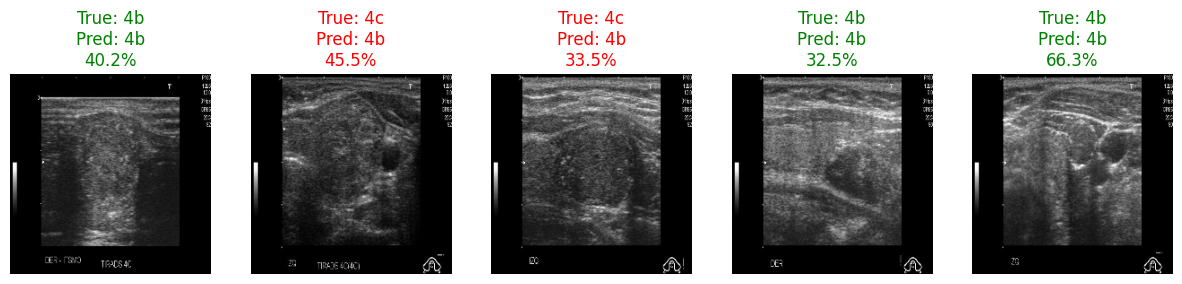

In [10]:
import matplotlib.pyplot as plt

def predict_tirads(model, X, y_true, encoder, num_samples=5):
    indices = np.random.choice(len(X), num_samples, replace=False)
    
    plt.figure(figsize=(15, 5))
    
    for i, idx in enumerate(indices):
        img = X[idx]
        
        # Predict
        pred_probs = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
        pred_idx = np.argmax(pred_probs)
        pred_label = encoder.classes_[pred_idx]
        confidence = pred_probs[pred_idx] * 100
        
        # True Label
        true_idx = np.argmax(y_true[idx])
        true_label = encoder.classes_[true_idx]
        
        color = 'green' if pred_label == true_label else 'red'
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {pred_label}\n{confidence:.1f}%", color=color)
        plt.axis('off')
        
    plt.show()

predict_tirads(cls_model, X_val_c, y_val_c, encoder)

In [6]:
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 1. Compute Class Weights (To handle imbalance)
# If we have many "4a" but few "5", this makes "5" more important.
y_integers = np.argmax(y_train_c, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# 2. Data Augmentation ( Crucial for small datasets )
# We flip, rotate, and zoom to make 1 image look like 10 different ones
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# We don't augment validation data, only rescale
val_datagen = ImageDataGenerator() # Already scaled to 0-1 in loader

train_generator = train_datagen.flow(X_train_c, y_train_c, batch_size=16)
val_generator = val_datagen.flow(X_val_c, y_val_c, batch_size=16)

Class Weights: {0: 1.2395833333333333, 1: 3.966666666666667, 2: 0.5666666666666667, 3: 0.6397849462365591, 4: 0.967479674796748, 5: 1.7246376811594204}


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model

def build_finetuned_classifier(num_classes):
    # Load Base Model
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    
    # UNFREEZE the last block of layers (Fine-Tuning)
    base_model.trainable = True
    # Freeze the earlier layers (generic shapes/edges)
    # MobileNetV2 has 155 layers. Let's freeze the first 100.
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # Added BatchNormalization for stability
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x) # High dropout to prevent overfitting
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=outputs)

# Build
num_classes = len(encoder.classes_)
cls_model_tuned = build_finetuned_classifier(num_classes)

# Compile with a very LOW learning rate for fine-tuning
cls_model_tuned.compile(
    optimizer=Adam(learning_rate=1e-5), # 10x slower than before
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

print("Fine-Tuned Model Built.")

Fine-Tuned Model Built.


In [8]:
# Callbacks to help training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Starting Improved Training...")

history_tuned = cls_model_tuned.fit(
    train_generator,
    steps_per_epoch=len(X_train_c) // 16,
    validation_data=val_generator,
    epochs=40, # More epochs needed because LR is low
    class_weight=class_weights_dict, # Use weights
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

# Save
cls_model_tuned.save("thyroid_tirads_tuned.keras")

Starting Improved Training...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 380ms/step - accuracy: 0.2297 - loss: 2.5099 - val_accuracy: 0.2167 - val_loss: 1.8698 - learning_rate: 1.0000e-05
Epoch 2/40
 1/14 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.0625 - loss: 3.1447

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.0625 - loss: 3.1447 - val_accuracy: 0.2167 - val_loss: 1.8698 - learning_rate: 1.0000e-05
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - accuracy: 0.1396 - loss: 2.9982 - val_accuracy: 0.2167 - val_loss: 1.8672 - learning_rate: 1.0000e-05
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1250 - loss: 3.0902 - val_accuracy: 0.2167 - val_loss: 1.8672 - learning_rate: 1.0000e-05
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.1652 - loss: 2.8019 - val_accuracy: 0.2167 - val_loss: 1.8738 - learning_rate: 1.0000e-05
Epoch 6/40
 1/14 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.1429 - loss: 2.7929
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.1429 - loss: 2.7929 - val_accuracy: 0.2167 - val_loss: 1.8747 - learning_rate: 1.0000e-05
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.1982 - loss: 2.51

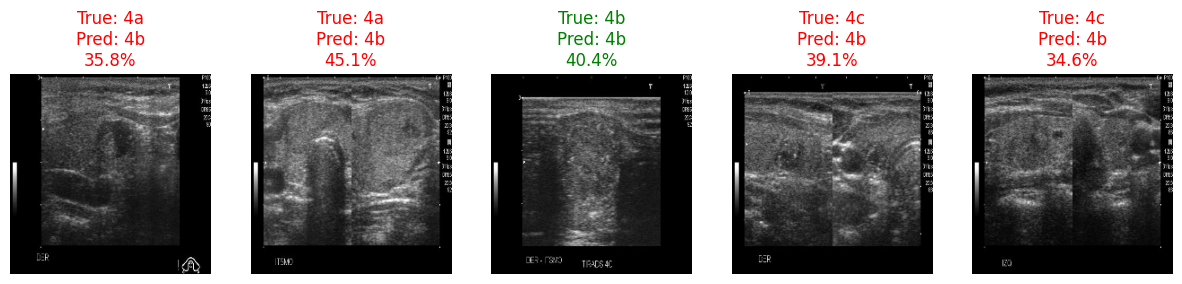

In [11]:
# Reuse the predict function
predict_tirads(cls_model_tuned, X_val_c, y_val_c, encoder)

Simplifying Labels...
Original Data: 298
Simplified Data: 298
New Class Weights: {0: 1.8888888888888888, 1: 0.45857418111753373, 2: 3.449275362318841}
Training Simplified Model...
Epoch 1/30


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.2941 - loss: 1.8794 - val_accuracy: 0.1833 - val_loss: 1.5234 - learning_rate: 1.0000e-05
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.3866 - loss: 1.5207 - val_accuracy: 0.1833 - val_loss: 1.5258 - learning_rate: 1.0000e-05
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.3739 - loss: 1.4010 - val_accuracy: 0.2167 - val_loss: 1.5346 - learning_rate: 1.0000e-05
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3677 - loss: 1.6152
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3739 - loss: 1.4014 - val_accuracy: 0.2167 - val_loss: 1.5861 - learning_rate: 1.0000e-05
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.3908 - loss: 1.4147 - val_accuracy: 0.2500 - val_loss: 1.5631 - learning_rate: 2.0000e-06
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.3235 - loss: 1.4686 - val_ac

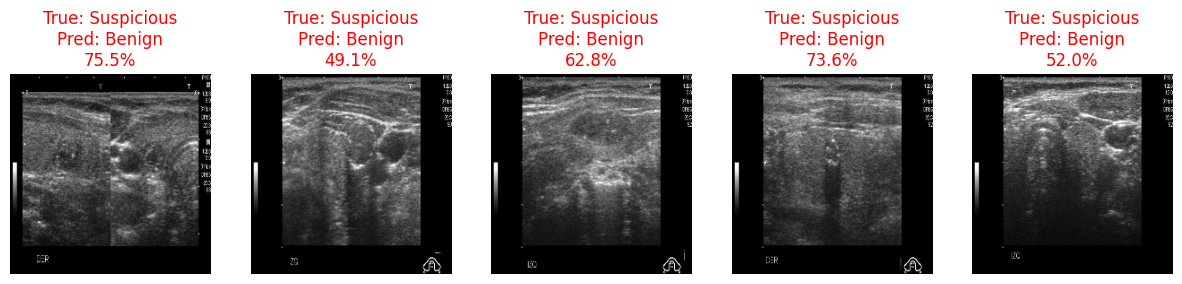

In [12]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# 1. Simplify Labels
# Map textual labels to 3 simple groups
label_mapping = {
    '2': 0, '3': 0,             # Benign
    '4a': 1, '4b': 1, '4c': 1,  # Suspicious
    '5': 2                      # Malignant
}

print("Simplifying Labels...")
y_simple = []
valid_indices = []

for i, label in enumerate(y_text):
    if label in label_mapping:
        y_simple.append(label_mapping[label])
        valid_indices.append(i)

# Filter images to match valid labels
X_simple = X_cls[valid_indices]
y_simple = np.array(y_simple)
y_categorical_simple = to_categorical(y_simple, num_classes=3)

print(f"Original Data: {len(y_text)}")
print(f"Simplified Data: {len(y_simple)}")

# Split
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(X_simple, y_categorical_simple, test_size=0.2, random_state=42)

# Compute Weights
y_integers = np.argmax(y_train_s, axis=1)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)
weights_dict = dict(enumerate(class_weights))
print("New Class Weights:", weights_dict)

# 2. Data Augmentation (Milder)
train_datagen = ImageDataGenerator(
    rotation_range=10,       # Less rotation
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train_s, y_train_s, batch_size=16)
val_gen = val_datagen.flow(X_val_s, y_val_s, batch_size=16)

# 3. Stronger Model (DenseNet121)
# DenseNet is often better for medical imaging textures than MobileNet
def build_densenet_model():
    base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = True # Fine-tune all layers
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(3, activation='softmax')(x)
    
    return Model(inputs=base_model.input, outputs=outputs)

model_simple = build_densenet_model()
model_simple.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Train
print("Training Simplified Model...")
history_simple = model_simple.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=weights_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    ],
    verbose=1
)

# 5. Test
def predict_simple(model, X, y_true):
    classes = ['Benign', 'Suspicious', 'Malignant']
    indices = np.random.choice(len(X), 5, replace=False)
    plt.figure(figsize=(15, 5))
    
    for i, idx in enumerate(indices):
        img = X[idx]
        pred = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
        label_pred = classes[np.argmax(pred)]
        label_true = classes[np.argmax(y_true[idx])]
        conf = np.max(pred) * 100
        
        color = 'green' if label_pred == label_true else 'red'
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"True: {label_true}\nPred: {label_pred}\n{conf:.1f}%", color=color)
        plt.axis('off')
    plt.show()

predict_simple(model_simple, X_val_s, y_val_s)

In [14]:
import cv2
import numpy as np
import os
import re
import json
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

def debug_crop_loader(base_path):
    print("--- DIAGNOSTIC CROP LOADER ---")
    
    # 1. Index Images
    image_map = {}
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                nums = re.findall(r'\d+', file)
                if nums:
                    key = int(max(nums, key=len)) 
                    image_map[key] = os.path.join(root, file)
    
    print(f"Indexed {len(image_map)} images in map.")
    if len(image_map) > 0:
        print(f"Sample Key: {list(image_map.keys())[0]} -> {list(image_map.values())[0]}")

    # 2. Scan XMLs
    xml_count = 0
    match_count = 0
    label_count = 0
    crop_count = 0
    
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.xml'):
                xml_count += 1
                nums = re.findall(r'\d+', file)
                if not nums: continue
                xml_key = int(max(nums, key=len))
                
                # CHECK 1: Does Image Exist?
                if xml_key not in image_map:
                    if xml_count < 5: print(f"FAIL: No image for XML ID {xml_key}")
                    continue
                match_count += 1
                
                try:
                    tree = ET.parse(os.path.join(root, file))
                    root_xml = tree.getroot()
                    
                    # CHECK 2: Does Label Exist?
                    tirads = root_xml.find('.//tirads')
                    if tirads is None or not tirads.text or tirads.text in ['Unknown', 'None']:
                        if xml_count < 5: print(f"FAIL: ID {xml_key} has no valid TI-RADS label.")
                        continue
                    label_count += 1
                    
                    # CHECK 3: Can we find Crop Points?
                    marks = root_xml.findall('.//mark')
                    all_points = []
                    for mark in marks:
                        svg = mark.find('svg')
                        if svg is not None and svg.text:
                            try:
                                shapes = json.loads(svg.text)
                                for shape in shapes:
                                    points = shape.get('points', [])
                                    for p in points:
                                        all_points.append([int(p['x']), int(p['y'])])
                            except: pass
                    
                    if not all_points:
                        if xml_count < 5: print(f"FAIL: ID {xml_key} has label {tirads.text} but NO crop points (JSON error?)")
                        continue
                    
                    crop_count += 1
                    if crop_count == 1:
                        print(f"SUCCESS: ID {xml_key} fully valid. Label: {tirads.text}, Points found.")

                except Exception as e:
                    print(f"Error parsing {file}: {e}")

    print("\n--- SUMMARY ---")
    print(f"Total XMLs found: {xml_count}")
    print(f"Images Matched:   {match_count}")
    print(f"Valid Labels:     {label_count}")
    print(f"Valid Crops:      {crop_count}")

debug_crop_loader(dataset_path)

--- DIAGNOSTIC CROP LOADER ---
Indexed 390 images in map.
Sample Key: 100 -> /teamspace/studios/this_studio/.cache/kagglehub/datasets/dasmehdixtr/ddti-thyroid-ultrasound-images/versions/1/100_1.jpg
FAIL: ID 1 has no valid TI-RADS label.
SUCCESS: ID 10 fully valid. Label: 4b, Points found.

--- SUMMARY ---
Total XMLs found: 390
Images Matched:   390
Valid Labels:     298
Valid Crops:      291


Loading dataset...


Loaded 291 images.
Final Cleaned Size: 291
Extracting Features...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 961ms/step
Training SVM...
SVM Accuracy: 55.93%
              precision    recall  f1-score   support

      Benign       0.25      0.38      0.30         8
  Suspicious       0.81      0.67      0.73        43
   Malignant       0.09      0.12      0.11         8

    accuracy                           0.56        59
   macro avg       0.38      0.39      0.38        59
weighted avg       0.63      0.56      0.59        59



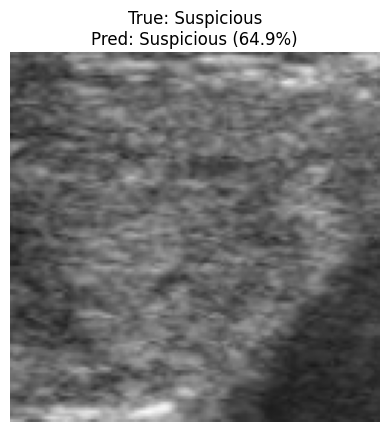

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

def load_and_process_crops(base_path, img_size=(128, 128)):
    images = []
    labels = []
    
    # Index Images
    image_map = {}
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                nums = re.findall(r'\d+', file)
                if nums:
                    key = int(max(nums, key=len)) 
                    image_map[key] = os.path.join(root, file)
    
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.xml'):
                nums = re.findall(r'\d+', file)
                if not nums: continue
                xml_key = int(max(nums, key=len))
                
                if xml_key in image_map:
                    try:
                        tree = ET.parse(os.path.join(root, file))
                        root_xml = tree.getroot()
                        
                        # Get Label
                        tirads = root_xml.find('.//tirads')
                        if tirads is None or tirads.text in ['Unknown', 'None', '', None]:
                            continue
                        label_text = tirads.text.strip()
                        
                        # Get Points
                        all_points = []
                        marks = root_xml.findall('.//mark')
                        for mark in marks:
                            svg = mark.find('svg')
                            if svg is not None and svg.text:
                                try:
                                    shapes = json.loads(svg.text)
                                    for shape in shapes:
                                        points = shape.get('points', [])
                                        for p in points:
                                            all_points.append([int(p['x']), int(p['y'])])
                                except: pass
                        
                        if not all_points: continue
                        
                        # Crop
                        all_points = np.array(all_points)
                        x_min, y_min = np.min(all_points, axis=0)
                        x_max, y_max = np.max(all_points, axis=0)
                        
                        # Padding
                        pad = 10
                        img = cv2.imread(image_map[xml_key])
                        if img is None: continue
                        h, w = img.shape[:2]
                        
                        x_min = max(0, x_min - pad)
                        y_min = max(0, y_min - pad)
                        x_max = min(w, x_max + pad)
                        y_max = min(h, y_max + pad)
                        
                        roi = img[y_min:y_max, x_min:x_max]
                        if roi.size == 0: continue
                        
                        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
                        roi = cv2.resize(roi, img_size)
                        
                        images.append(roi)
                        labels.append(label_text)
                    except: pass
                    
    return np.array(images), np.array(labels)

# 1. Load Data
print("Loading dataset...")
X_crop, y_raw = load_and_process_crops(dataset_path)
print(f"Loaded {len(X_crop)} images.")

if len(X_crop) > 0:
    # 2. Map Labels
    label_mapping = {
        '2': 0, '3': 0,             # Benign
        '4a': 1, '4b': 1, '4c': 1,  # Suspicious
        '5': 2                      # Malignant
    }

    y_simple = []
    X_final = []
    for i, label in enumerate(y_raw):
        if label in label_mapping:
            y_simple.append(label_mapping[label])
            X_final.append(X_crop[i])

    X_final = np.array(X_final)
    y_simple = np.array(y_simple)
    print(f"Final Cleaned Size: {len(X_final)}")

    # 3. Extract Features (VGG16)
    print("Extracting Features...")
    X_pre = preprocess_input(X_final.copy())
    vgg = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(128, 128, 3))
    features = vgg.predict(X_pre)

    # 4. Train SVM
    print("Training SVM...")
    X_train, X_test, y_train, y_test = train_test_split(features, y_simple, test_size=0.2, random_state=42)
    
    svm = SVC(kernel='rbf', C=1.0, class_weight='balanced', probability=True)
    svm.fit(X_train, y_train)

    # 5. Results
    y_pred = svm.predict(X_test)
    print(f"SVM Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
    print(classification_report(y_test, y_pred, target_names=['Benign', 'Suspicious', 'Malignant']))
    
    # 6. Visual Test
    def test_svm_prediction(idx):
        img = X_final[idx]
        feat = vgg.predict(preprocess_input(np.expand_dims(img, axis=0)), verbose=0)
        probs = svm.predict_proba(feat)[0]
        pred_cls = np.argmax(probs)
        classes = ['Benign', 'Suspicious', 'Malignant']
        
        plt.imshow(img)
        plt.title(f"True: {classes[y_simple[idx]]}\nPred: {classes[pred_cls]} ({probs[pred_cls]*100:.1f}%)")
        plt.axis('off')
        plt.show()

    test_svm_prediction(0)
else:
    print("Still no images loaded. Check Diagnostic output.")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Applying SMOTE to balance the dataset...
Original Train Counts: [ 43 167  22]
Balanced Train Counts: [167 167 167]

Training Random Forest on Balanced Data...
Random Forest Accuracy: 74.58%
              precision    recall  f1-score   support

      Benign       0.50      0.12      0.20         8
  Suspicious       0.75      1.00      0.86        43
   Malignant       0.00      0.00      0.00         8

    accuracy                           0.75        59
   macro avg       0.42      0.38      0.35        59
weighted avg       0.62      0.75      0.65        59

Optimizing SVM...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"


Optimized SVM Accuracy: 72.88%
              precision    recall  f1-score   support

      Benign       0.50      0.12      0.20         8
  Suspicious       0.74      0.98      0.84        43
   Malignant       0.00      0.00      0.00         8

    accuracy                           0.73        59
   macro avg       0.41      0.37      0.35        59
weighted avg       0.60      0.73      0.64        59

Best SVM Params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Visualizing Random Test Samples...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

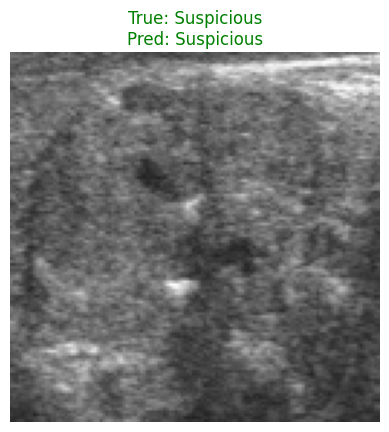

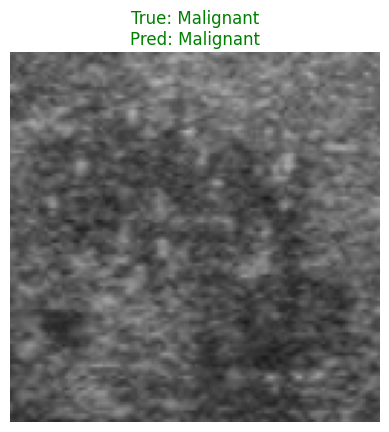

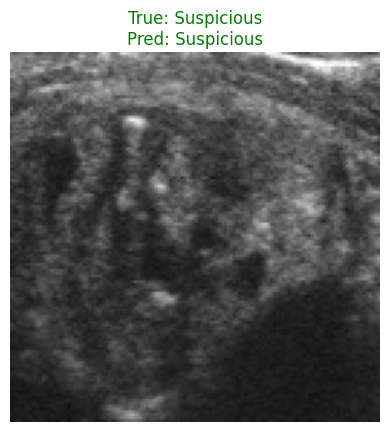

In [17]:
# 1. Install SMOTE
!pip install -q imbalanced-learn

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

print("Applying SMOTE to balance the dataset...")

# 1. Split Data (Features from VGG16)
# We split BEFORE SMOTE. Never apply SMOTE to the Test set!
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(features, y_simple, test_size=0.2, random_state=42)

print(f"Original Train Counts: {np.bincount(y_train_f)}")
# Likely something like [30, 150, 30]

# 2. Apply SMOTE
# This creates synthetic Benign and Malignant features to match the Suspicious count
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_f, y_train_f)

print(f"Balanced Train Counts: {np.bincount(y_train_res)}")
# Now it should be [150, 150, 150]

# 3. Train Random Forest (Often better for this than SVM)
print("\nTraining Random Forest on Balanced Data...")
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train_res, y_train_res)

# Evaluate RF
y_pred_rf = rf.predict(X_test_f)
print(f"Random Forest Accuracy: {accuracy_score(y_test_f, y_pred_rf)*100:.2f}%")
print(classification_report(y_test_f, y_pred_rf, target_names=['Benign', 'Suspicious', 'Malignant']))

# 4. Train SVM (With Grid Search Optimization)
print("Optimizing SVM...")
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=0)
grid.fit(X_train_res, y_train_res)

y_pred_svm = grid.predict(X_test_f)
print(f"\nOptimized SVM Accuracy: {accuracy_score(y_test_f, y_pred_svm)*100:.2f}%")
print(classification_report(y_test_f, y_pred_svm, target_names=['Benign', 'Suspicious', 'Malignant']))
print(f"Best SVM Params: {grid.best_params_}")

# 5. Visualization of the Best Model
best_model = rf if accuracy_score(y_test_f, y_pred_rf) > accuracy_score(y_test_f, y_pred_svm) else grid

def visualize_final_prediction(idx):
    # Get original image and label
    img = X_final[idx] # Use the cropped image array from previous step
    true_label = y_simple[idx]
    
    # Get features again for this specific image
    feat = features[idx].reshape(1, -1)
    
    # Predict
    pred_cls = best_model.predict(feat)[0]
    classes = ['Benign', 'Suspicious', 'Malignant']
    
    color = 'green' if pred_cls == true_label else 'red'
    
    plt.imshow(img)
    plt.title(f"True: {classes[true_label]}\nPred: {classes[pred_cls]}", color=color)
    plt.axis('off')
    plt.show()

print("\nVisualizing Random Test Samples...")
import random
for _ in range(3):
    visualize_final_prediction(random.randint(0, len(X_final)-1))

Example Raw Probabilities (First 5):
[[0.21316467 0.73040538 0.05642995]
 [0.34809132 0.58628499 0.06562369]
 [0.14265568 0.64018148 0.21716284]
 [0.22281979 0.4303901  0.34679011]
 [0.26475294 0.68047961 0.05476744]]

--- Risk-Sensitive Evaluation ---
              precision    recall  f1-score   support

      Benign       0.50      0.12      0.20         8
  Suspicious       0.76      0.81      0.79        43
   Malignant       0.18      0.25      0.21         8

    accuracy                           0.64        59
   macro avg       0.48      0.40      0.40        59
weighted avg       0.65      0.64      0.63        59



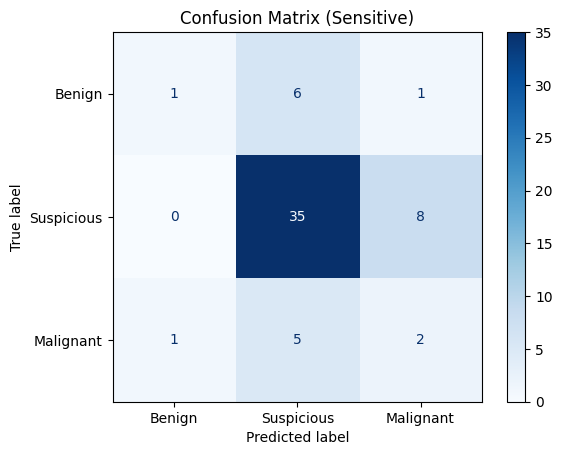

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Get Raw Probabilities instead of just Labels
# Format: [Prob_Benign, Prob_Suspicious, Prob_Malignant]
probs = rf.predict_proba(X_test_f)

print("Example Raw Probabilities (First 5):")
print(probs[:5])

# 2. Apply Medical Risk Thresholding
def medical_threshold_prediction(probability_list):
    predictions = []
    for p in probability_list:
        # p[0] = Benign, p[1] = Suspicious, p[2] = Malignant
        
        # RULE 1: High sensitivity for Cancer
        # If model is at least 25% sure it's Malignant, call it Malignant
        if p[2] > 0.25:
            predictions.append(2) # Malignant
            
        # RULE 2: If not malignant, check for Suspicious
        elif p[1] > p[0]: 
            predictions.append(1) # Suspicious
            
        # Else, it's Benign
        else:
            predictions.append(0) # Benign
            
    return np.array(predictions)

# 3. Generate New Predictions
y_pred_sensitive = medical_threshold_prediction(probs)

# 4. Re-Evaluate
print("\n--- Risk-Sensitive Evaluation ---")
print(classification_report(y_test_f, y_pred_sensitive, target_names=['Benign', 'Suspicious', 'Malignant']))

# 5. Visualize Confusion Matrix
cm = confusion_matrix(y_test_f, y_pred_sensitive)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Suspicious', 'Malignant'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Sensitive)")
plt.show()

In [19]:
import joblib

# Save the Random Forest Model
joblib.dump(rf, 'thyroid_rf_classifier.pkl')
print("Random Forest Classifier saved as 'thyroid_rf_classifier.pkl'")

# Note: To use this later, you will need to:
# 1. Load VGG16 (standard weights)
# 2. Extract features from your image
# 3. Load this RF model -> rf = joblib.load('thyroid_rf_classifier.pkl')
# 4. Run rf.predict(features)

Random Forest Classifier saved as 'thyroid_rf_classifier.pkl'


Loading Segmentation Model...
Loading Classification Model...
Loading Feature Extractor (VGG16)...

--- RUNNING DIAGNOSIS ---


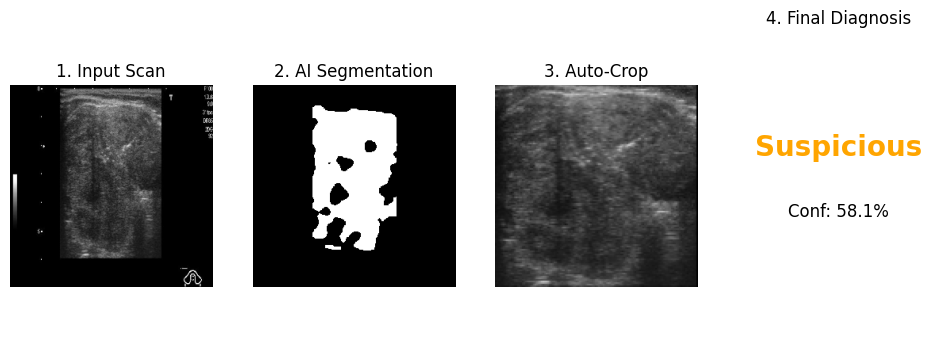

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.layers import Input

# ==========================================
# 1. SETUP & LOADING
# ==========================================

# Define Custom Loss (Needed to load Segmentation Model)
def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

print("Loading Segmentation Model...")
seg_model = load_model('thyroid_final_corrected.keras', custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef})

print("Loading Classification Model...")
rf_model = joblib.load('thyroid_rf_classifier.pkl')

print("Loading Feature Extractor (VGG16)...")
# We re-initialize VGG16 because we didn't save the base VGG model, only the RF
vgg = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(128, 128, 3))

# ==========================================
# 2. THE DIAGNOSTIC FUNCTION
# ==========================================
def diagnose_patient(image_array):
    """
    Takes a raw image array, segments it, crops it, and classifies it.
    """
    # --- A. PREPARE FOR SEGMENTATION ---
    # Resize to 256x256 for U-Net
    img_seg_in = cv2.resize(image_array, (256, 256))
    img_seg_norm = img_seg_in / 255.0
    img_seg_batch = np.expand_dims(img_seg_norm, axis=0)
    
    # --- B. SEGMENTATION ---
    pred_mask = seg_model.predict(img_seg_batch, verbose=0)[0]
    # Adaptive threshold
    threshold = 0.3 if pred_mask.max() > 0.3 else 0.5
    pred_mask_bin = (pred_mask > threshold).astype(np.uint8)
    
    # --- C. ROI CROPPING ---
    # Find contours in the mask to get bounding box
    contours, _ = cv2.findContours(pred_mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return img_seg_in, pred_mask_bin, None, "No Nodule Detected", 0.0
    
    # Get largest contour (the main nodule)
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    
    # Add padding
    pad = 10
    x = max(0, x - pad)
    y = max(0, y - pad)
    w = min(256 - x, w + 2*pad)
    h = min(256 - y, h + 2*pad)
    
    # Crop from the 256x256 image
    crop = img_seg_in[y:y+h, x:x+w]
    
    # --- D. CLASSIFICATION ---
    # Resize crop to 128x128 for VGG
    crop_vgg = cv2.resize(crop, (128, 128))
    crop_batch = np.expand_dims(crop_vgg, axis=0)
    
    # Extract Features
    crop_pre = preprocess_input(crop_batch.copy()) # VGG preprocessing
    features = vgg.predict(crop_pre, verbose=0)
    
    # Predict Probabilities
    probs = rf_model.predict_proba(features)[0]
    
    # Risk-Sensitive Logic
    if probs[2] > 0.25: 
        diagnosis = "Malignant"
        confidence = probs[2]
    elif probs[1] > probs[0]:
        diagnosis = "Suspicious"
        confidence = probs[1]
    else:
        diagnosis = "Benign"
        confidence = probs[0]
        
    return img_seg_in, pred_mask_bin, crop_vgg, diagnosis, confidence

# ==========================================
# 3. RUN DEMO
# ==========================================
# Pick a random image from validation set to test
import random
idx = random.randint(0, len(X_val))
test_image = X_val[idx] # This is already normalized 0-1 float

# Convert back to 0-255 uint8 for the function
test_image_uint8 = (test_image * 255).astype(np.uint8)

print("\n--- RUNNING DIAGNOSIS ---")
original, mask, crop, diag, conf = diagnose_patient(test_image_uint8)

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(original)
plt.title("1. Input Scan")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title("2. AI Segmentation")
plt.axis('off')

if crop is not None:
    plt.subplot(1, 4, 3)
    plt.imshow(crop)
    plt.title("3. Auto-Crop")
    plt.axis('off')
else:
    plt.subplot(1, 4, 3)
    plt.text(0.5, 0.5, "No Nodule", ha='center')
    plt.axis('off')

plt.subplot(1, 4, 4)
color = 'red' if diag == 'Malignant' else 'orange' if diag == 'Suspicious' else 'green'
plt.text(0.5, 0.6, diag, fontsize=20, color=color, ha='center', weight='bold')
plt.text(0.5, 0.4, f"Conf: {conf*100:.1f}%", fontsize=12, ha='center')
plt.title("4. Final Diagnosis")
plt.axis('off')

plt.show()

--- 1. SETUP ---
Indexing images...
Indexed 390 images.
Processing XMLs (Applying JSON Fix)...


Successfully loaded 291 crops.
Boosting Malignant Cases...

--- 2. TRAINING ---
Training Count: 651
Extracting Features (VGG16)...
Training Ensemble Classifier...

Results:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        16
  Suspicious       0.67      0.87      0.76        85
   Malignant       0.48      0.33      0.39        30

    accuracy                           0.64       131
   macro avg       0.38      0.40      0.38       131
weighted avg       0.55      0.64      0.58       131


--- 3. VISUALIZATION ---


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"

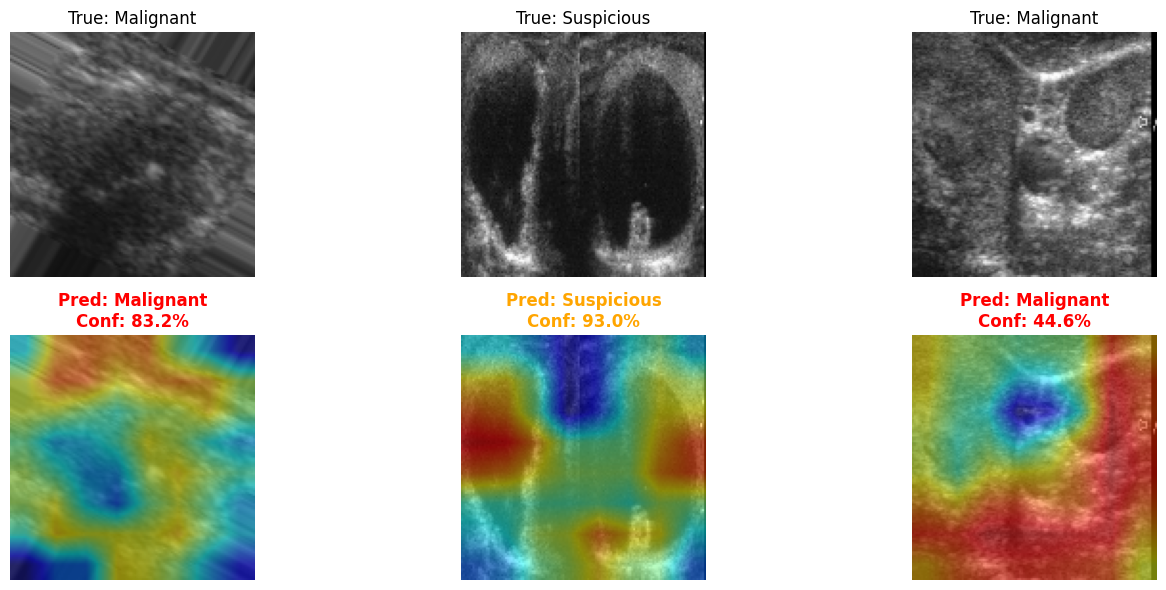

In [49]:
import os
import cv2
import numpy as np
import re
import json
import xml.etree.ElementTree as ET
import kagglehub
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model

# ==========================================
# 1. SETUP & FIXED DATA LOADER
# ==========================================
print("--- 1. SETUP ---")
try:
    dataset_path = kagglehub.dataset_download("dasmehdixtr/ddti-thyroid-ultrasound-images")
except:
    dataset_path = "dataset" # Fallback

def load_and_boost_data_robust(base_path, img_size=(128, 128)):
    images = []
    labels = []
    image_map = {}
    
    print("Indexing images...")
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                nums = re.findall(r'\d+', file)
                if nums:
                    # Map ID "100" to path
                    image_map[int(max(nums, key=len))] = os.path.join(root, file)
    
    print(f"Indexed {len(image_map)} images.")
    print("Processing XMLs (Applying JSON Fix)...")
    
    valid_count = 0
    
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.xml'):
                nums = re.findall(r'\d+', file)
                if not nums: continue
                xml_key = int(max(nums, key=len))
                
                if xml_key in image_map:
                    try:
                        tree = ET.parse(os.path.join(root, file))
                        root_xml = tree.getroot()
                        
                        # Extract Label
                        tirads = root_xml.find('.//tirads')
                        if tirads is None or tirads.text in ['Unknown', 'None', '', None]: continue
                        label_text = tirads.text.strip()
                        
                        # Extract Crop Points (With JSON Fix)
                        marks = root_xml.findall('.//mark')
                        all_points = []
                        for mark in marks:
                            svg = mark.find('svg')
                            if svg is not None and svg.text:
                                try:
                                    # --- THE FIX: Replace single quotes with double quotes ---
                                    json_text = svg.text.replace("'", '"')
                                    shapes = json.loads(json_text)
                                    
                                    for shape in shapes:
                                        points = shape.get('points', [])
                                        for p in points:
                                            all_points.append([int(p['x']), int(p['y'])])
                                except: pass
                        
                        if not all_points: continue
                        
                        # Perform Crop
                        all_points = np.array(all_points)
                        img = cv2.imread(image_map[xml_key])
                        if img is None: continue
                        h, w = img.shape[:2]
                        
                        pad = 15
                        x_min = max(0, np.min(all_points[:,0]) - pad)
                        y_min = max(0, np.min(all_points[:,1]) - pad)
                        x_max = min(w, np.max(all_points[:,0]) + pad)
                        y_max = min(h, np.max(all_points[:,1]) + pad)
                        
                        crop = img[y_min:y_max, x_min:x_max]
                        if crop.size == 0: continue
                        
                        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
                        crop = cv2.resize(crop, img_size)
                        
                        images.append(crop)
                        labels.append(label_text)
                        valid_count += 1
                    except: pass

    print(f"Successfully loaded {valid_count} crops.")
    
    # Map Labels
    label_mapping = {'2': 0, '3': 0, '4a': 1, '4b': 1, '4c': 1, '5': 2}
    X, y = [], []
    for i, label in enumerate(labels):
        if label in label_mapping:
            X.append(images[i])
            y.append(label_mapping[label])
            
    X = np.array(X)
    y = np.array(y, dtype=int)
    
    if len(y) == 0: return None, None

    # Physical Boosting (Augmentation)
    print("Boosting Malignant Cases...")
    X_boosted = list(X)
    y_boosted = list(y)
    datagen = ImageDataGenerator(rotation_range=45, horizontal_flip=True, vertical_flip=True, zoom_range=0.1)
    
    for i in range(len(y)):
        # Boost Malignant (Class 2) x5
        if y[i] == 2:
            aug_iter = datagen.flow(np.expand_dims(X[i], 0), batch_size=1)
            for _ in range(5):
                # --- FIX: Use next(aug_iter) instead of aug_iter.next() ---
                X_boosted.append(next(aug_iter)[0].astype(np.uint8))
                y_boosted.append(2)
        # Boost Suspicious (Class 1) x1
        elif y[i] == 1:
            aug_iter = datagen.flow(np.expand_dims(X[i], 0), batch_size=1)
            for _ in range(1):
                X_boosted.append(next(aug_iter)[0].astype(np.uint8))
                y_boosted.append(1)
                
    return np.array(X_boosted), np.array(y_boosted)

# Load
X_final, y_final = load_and_boost_data_robust(dataset_path)

# ==========================================
# 2. TRAIN ENSEMBLE (RF + SVM)
# ==========================================
if X_final is not None:
    print("\n--- 2. TRAINING ---")
    print(f"Training Count: {len(y_final)}")
    
    # Extract Features
    print("Extracting Features (VGG16)...")
    vgg = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(128, 128, 3))
    X_pre = preprocess_input(X_final.copy())
    features = vgg.predict(X_pre, verbose=0)
    
    # Train
    print("Training Ensemble Classifier...")
    X_train, X_test, y_train, y_test = train_test_split(features, y_final, test_size=0.2, random_state=42)
    
    clf1 = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    clf2 = SVC(kernel='rbf', probability=True, class_weight='balanced')
    eclf = VotingClassifier(estimators=[('rf', clf1), ('svc', clf2)], voting='soft')
    eclf.fit(X_train, y_train)
    
    # Eval
    y_pred = eclf.predict(X_test)
    print("\nResults:")
    print(classification_report(y_test, y_pred, target_names=['Benign', 'Suspicious', 'Malignant']))

    # ==========================================
    # 3. VISUALIZATION WITH HEATMAP
    # ==========================================
    print("\n--- 3. VISUALIZATION ---")
    
    # Setup Heatmap Model
    last_conv_layer = vgg.get_layer('block5_conv3')
    heatmap_model = Model(vgg.input, last_conv_layer.output)

    def get_heatmap(img_crop):
        img_pre = preprocess_input(np.expand_dims(img_crop, axis=0))
        conv_out = heatmap_model.predict(img_pre, verbose=0)
        
        # Average filters to get activation map
        heatmap = np.mean(conv_out[0], axis=-1)
        heatmap = np.maximum(heatmap, 0) 
        if np.max(heatmap) != 0: heatmap /= np.max(heatmap)
        
        heatmap = cv2.resize(heatmap, (img_crop.shape[1], img_crop.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        return cv2.addWeighted(heatmap, 0.5, img_crop, 0.5, 0)

    # Pick random samples from Test Set
    indices = np.random.choice(len(X_test), 3, replace=False)
    
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(indices):
        # Map back to original image logic is hard because we split features, 
        # so we just pick a fresh random from the dataset to show capability
        demo_idx = np.random.randint(0, len(X_final))
        img_demo = X_final[demo_idx]
        true_label = y_final[demo_idx]
        
        # Predict
        feat_demo = vgg.predict(preprocess_input(np.expand_dims(img_demo, axis=0)), verbose=0)
        probs = eclf.predict_proba(feat_demo)[0]
        
        # Logic
        if probs[2] > 0.30: pred="Malignant"; col='red'; conf=probs[2]
        elif probs[1] > probs[0]: pred="Suspicious"; col='orange'; conf=probs[1]
        else: pred="Benign"; col='green'; conf=probs[0]
        
        classes = ['Benign', 'Suspicious', 'Malignant']
        true_text = classes[true_label]
        
        # Heatmap
        hmap = get_heatmap(img_demo)
        
        # Plot
        plt.subplot(2, 3, i+1)
        plt.imshow(img_demo)
        plt.title(f"True: {true_text}")
        plt.axis('off')
        
        plt.subplot(2, 3, i+4)
        plt.imshow(hmap)
        plt.title(f"Pred: {pred}\nConf: {conf*100:.1f}%", color=col, weight='bold')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
else:
    print("Setup failed. Please check the dataset path output above.")

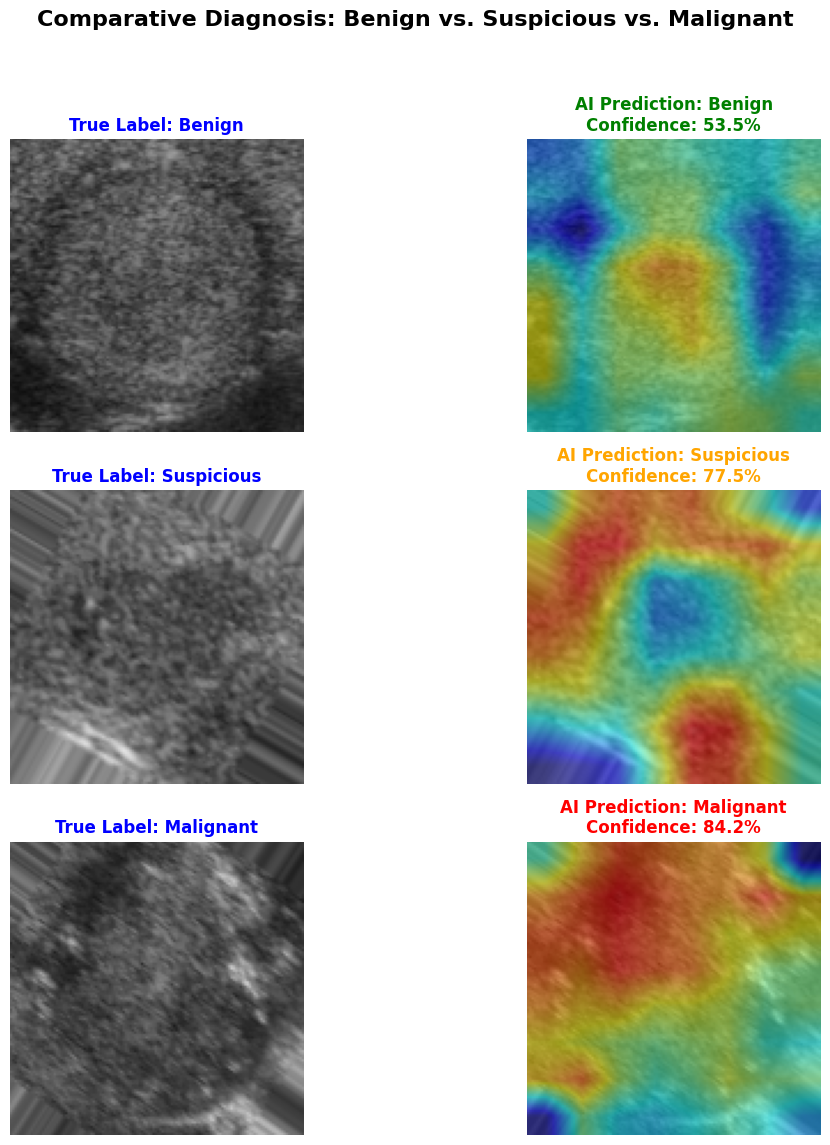

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input

def visualize_all_three_classes(X, y, vgg_model, clf_model):
    """
    Finds one random image for EACH class (Benign, Suspicious, Malignant)
    and visualizes the Image, Heatmap, and Prediction stats.
    """
    
    class_indices = [0, 1, 2] # 0=Benign, 1=Suspicious, 2=Malignant
    class_names = ['Benign', 'Suspicious', 'Malignant']
    
    plt.figure(figsize=(12, 12))
    plt.suptitle("Comparative Diagnosis: Benign vs. Suspicious vs. Malignant", fontsize=16, weight='bold')
    
    # Loop through each class type
    for row, target_class in enumerate(class_indices):
        # 1. Find indices where the TRUE label matches the target
        indices = np.where(y == target_class)[0]
        
        if len(indices) == 0:
            print(f"No samples found for class {class_names[target_class]}")
            continue
            
        # 2. Pick a random image from this class
        idx = np.random.choice(indices)
        img_demo = X[idx]
        
        # 3. Run Prediction Pipeline
        # Prepare for VGG
        img_batch = np.expand_dims(img_demo, axis=0)
        img_pre = preprocess_input(img_batch.copy())
        
        # Extract Features
        features = vgg_model.predict(img_pre, verbose=0)
        
        # Classifier Prediction
        probs = clf_model.predict_proba(features)[0]
        
        # 4. Apply Risk Logic
        if probs[2] > 0.30: 
            pred_label = "Malignant"
            conf = probs[2]
            color = 'red'
        elif probs[1] > probs[0]: 
            pred_label = "Suspicious"
            conf = probs[1]
            color = 'orange'
        else: 
            pred_label = "Benign"
            conf = probs[0]
            color = 'green'
            
        # 5. Generate Heatmap
        conv_out = heatmap_model.predict(img_pre, verbose=0)
        heatmap = np.mean(conv_out[0], axis=-1)
        heatmap = np.maximum(heatmap, 0)
        if np.max(heatmap) != 0: heatmap /= np.max(heatmap)
        
        heatmap = cv2.resize(heatmap, (img_demo.shape[1], img_demo.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap_overlay = cv2.addWeighted(heatmap, 0.5, img_demo, 0.5, 0)
        
        # --- PLOTTING ---
        
        # Column 1: Original Image
        plt.subplot(3, 2, row * 2 + 1)
        plt.imshow(img_demo)
        plt.title(f"True Label: {class_names[target_class]}", fontsize=12, weight='bold', color='blue')
        plt.axis('off')
        
        # Column 2: Heatmap & Prediction
        plt.subplot(3, 2, row * 2 + 2)
        plt.imshow(heatmap_overlay)
        
        # Add Text Info to the plot
        info_text = f"AI Prediction: {pred_label}\nConfidence: {conf*100:.1f}%"
        plt.title(info_text, fontsize=12, weight='bold', color=color)
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Check if data exists before running
if 'X_final' in locals() and 'y_final' in locals():
    visualize_all_three_classes(X_final, y_final, vgg, eclf)
else:
    print("Data not found. Please run the training cell above first.")